In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.font_manager import fontManager, FontProperties
import ptitprince as pt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
import pingouin as pg
import statsmodels.api as sm
%matplotlib inline


def get_img(name):
     path = "font/emojis/{}.png".format(name)
     im = plt.imread(path)
     return im

def offset_image(coord, name, ax, size=0.5):
    img = get_img(name)
    im = OffsetImage(img, zoom=size)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -21.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)

def raincloud(x, y, markersize, df, order=None, hue=None):
    # adding color
    pal = sns.color_palette()
    # f, ax = plt.subplots(figsize=(5*2.5, 5*2.5))

    if df is not None:
        means = df.groupby([x])[y].mean().reindex(order)
    else:
        if len(order) > 2:
            raise Exception('Too many unique x values for this custom plot')

        mean_1 = np.mean([i[0] for i in zip(y, x) if i[1] == order[0]])
        mean_2 = np.mean([i[0] for i in zip(y, x) if i[1] == order[1]])
        means = [mean_1, mean_2]

    dodge = None
    if hue:
        means = df.groupby([x, hue])[y].mean().reindex(order)
        dodge = True
        
    sns.scatterplot(x=means.index, y=means, color='white', edgecolor='black', s=150/2, linewidth=1.5, zorder=4)

    ax = pt.half_violinplot(x=x, y=y, data=df, palette=pal, bw=.25, cut=0., linewidth=0, 
                            scale="area", width=.7, inner=None, orient='v', zorder=1, order=order, hue=hue, dodge=dodge)

    ax = sns.stripplot(x=x, y=y, data=df, palette=pal, edgecolor="white",  linewidth=1, order=order,
                       size=markersize, orient='v', zorder=2, jitter=1, alpha=0.6, hue=hue, dodge=dodge)


    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1,
     edgecolor='black', capsize=.06, zorder=3, bw=0, order=order, hue=hue, dodge=dodge)

In [33]:
df = pd.read_csv('HUMANS/turing_100.csv')
df = df[df.prolific_id.isin(df.prolific_id.value_counts()[df.prolific_id.value_counts() == 138].index)]

print("complete =", (df.groupby('prolific_id').prolific_id.count() == 138).sum())
print("incomplete =", (df.groupby('prolific_id').prolific_id.count() != 138).sum())
# print("dataset_id that are complete =", df.dataset_id.value_counts()==138)
print("dataset_id that are incomplete =", 
    [
        i for i in range(78)
        if i not in df.dataset_id.value_counts().index
    ])
print("dataset_id that are incomplete =", 
    len(
        [i for i in range(78) if i not in df.dataset_id.value_counts().index]))

df['correct'] = None
df['correct'] = df.correct.astype(bool)
df['agree1'] = None
df['agree1'] = df.agree1.astype(bool)
df['agree2'] = None
df['agree2'] = df.agree2.astype(bool)

df.loc[df.q_id==2, 'correct'] = df.source == df.answer
df.loc[df.q_id==1, 'agree2'] = df.answer.str.contains('Yes')
df.loc[df.q_id==0, 'agree1'] = df.answer.str.contains('Yes')


# clear weird characters in answers
df.loc[df.answer.str.contains('Yes'), 'answer'] = 'Yes'
df.loc[df.answer.str.contains('No'), 'answer'] = 'No'
df.loc[df.answer.str.contains('AI'), 'answer'] = 'AI'
df.loc[df.answer.str.contains('Human'), 'answer'] = 'Human'


# avg.head()
# print(sum(df.item_id.value_counts()))

# add correct and agree1 to all rows where item id is the same (easier to plot)
for i in df.item_id.unique():
    df.loc[df.item_id==i, 'correct'] = \
        df[(df.item_id==i) & (df.q_id==2)].correct.values[0]
    df.loc[df.item_id==i, 'agree1'] = \
        df[(df.item_id==i) & (df.q_id==0)].agree1.values[0]
    df.loc[df.item_id==i, 'agree2'] = \
        df[(df.item_id==i) & (df.q_id==1)].agree2.values[0]

    df.loc[df.item_id==i, 'turing'] = \
        df[(df.item_id==i) & (df.q_id==2)].answer.values[0]
    
# df['agree1']
df['agree_both'] = df.agree1 & df.agree2
df['disagree_both'] = ~df.agree1 & ~df.agree2


complete = 103
incomplete = 0
dataset_id that are incomplete = [31, 73, 74, 75, 76, 77]
dataset_id that are incomplete = 6


In [34]:
df.groupby(['prolific_id', 'dataset_id']).size()

prolific_id               dataset_id
5483702ffdf99b24c654b810  28            138
54b9acd9fdf99b34ce2578f9  20            138
5611f0b97ffc8a00128118c8  12            138
563f5535cbd4c60011dc9466  36            138
56818073c5767f00121d21c5  20            138
                                       ... 
63d2b847b533b122bdeb1c7c  50            138
63d3fe966280b6070db0d377  54            138
63d3fff8d2afe2d70a9202ba  59            138
63d4005611fc905186f61eac  6             138
63d401296ac856e37cce7cb9  9             138
Length: 105, dtype: int64

In [35]:
# bonus for correct answers
bonus = df[(df.q_id==2)].groupby('prolific_id').correct.sum() * .05
for row in bonus.iteritems():
    # if row 0 in 613ab311df99420815403fe9, 60772d61bc996f9fa5806f3f, 5effa1b1767027080863869d, 60e5cb4ca01a593fce9a379d, 6153144b6c389cb97e3169c3
    if row[0] not in [
        '613ab311df99420815403fe9',
        '60772d61bc996f9fa5806f3f',
        '5effa1b1767027080863869d',
        '60e5cb4ca01a593fce9a379d',
        '6153144b6c389cb97e3169c3'
    ]:
        print(row[0]+ ',' + str(round(row[1], 2)))

5483702ffdf99b24c654b810,0.9
54b9acd9fdf99b34ce2578f9,1.5
5611f0b97ffc8a00128118c8,1.3
563f5535cbd4c60011dc9466,1.25
56818073c5767f00121d21c5,1.5
56bdf97bef423f000dcbb7eb,1.7
58a95ef0bb9e0f0001acaa8b,1.55
5917090f1d55e90001cd06b9,0.85
59637ac5d6b02c0001439808,1.65
59873c08da239a0001fb878f,1.4
5a099b6ca383a100011b49ec,1.65
5b2a72f7c293b90001732b89,1.8
5b438f3f7aec830001bb1a9a,1.55
5b62ebb3c831f00001f60468,0.9
5b6362cefaf7d30001e379e7,1.7
5be4149956a76700012fc29a,1.5
5bf003ccaf38d100016bb945,2.0
5c12d53683c3cb0001172e89,1.55
5c3e6c9208a31d000166c3dc,1.25
5c473c74819d580001782651,1.7
5c9b8fb954d2830014af438f,0.95
5d0a775bccb8bb00179a04f1,1.35
5d1e1d8b084f39001aa73d27,1.55
5d5423acdefe1f000169c7a6,1.4
5d6ed96c3fe1ac001add3be8,1.0
5d810f1d569c4d0019ab0cee,0.95
5d8f382400980b0019e21098,1.05
5d93c8c883e2470018a4f853,1.5
5dc04aba55b86247c9991f89,1.2
5dd9508298981d8db119671d,1.9
5df227eb99b2821302e8dd5b,1.3
5e0ce898271305486010a645,1.4
5e0fa4276f6d3e6adfca658a,1.45
5e3fcea84a6a7f21121284d4,1.45

Text(0.5, 0, 'Trial')

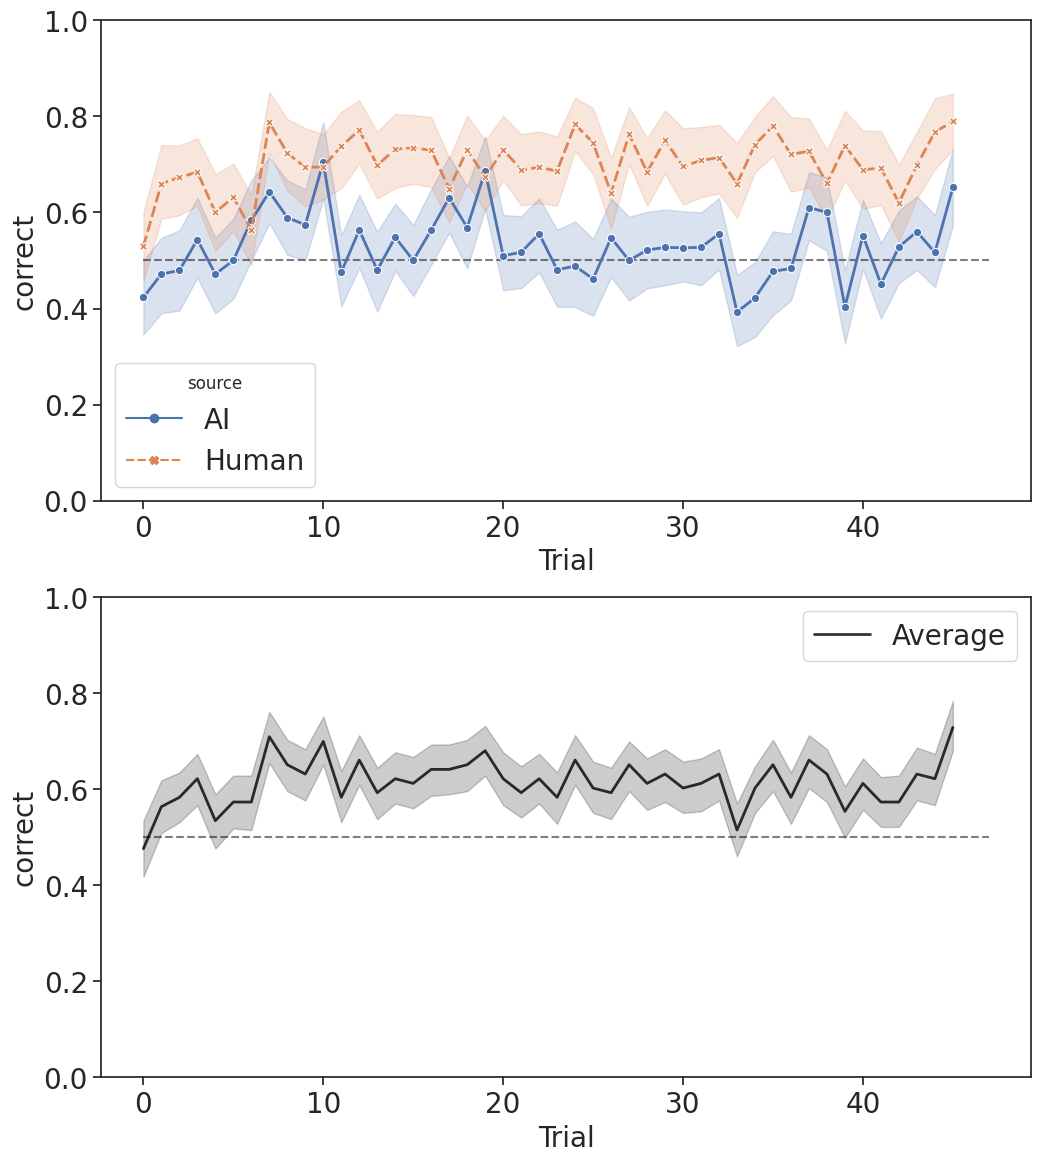

In [36]:
sns.set(
    rc={'figure.figsize':(12, 14), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 20,
        'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False}
)

sns.set_palette('deep')
sns.set_style("ticks")

# ----------------------------------------------------------------------------------------------------------------------
# PLOT 1
# ----------------------------------------------------------------------------------------------------------------------
plt.subplot(2, 1, 1)
plt.plot([0, 47], [0.5, 0.5], '--', color='black', alpha=0.5)
sns.lineplot(x='item_idx', y='correct', data=df, hue='source',  legend=True, linewidth=2, markers=True, style='source')
plt.ylim(0, 1)
plt.xlabel('Trial')

# ----------------------------------------------------------------------------------------------------------------------
# PLOT 2
# ----------------------------------------------------------------------------------------------------------------------
plt.subplot(2, 1, 2)
plt.plot([0, 47], [0.5, 0.5], '--', color='black', alpha=0.5)
sns.lineplot(x='item_idx', y='correct', data=df, color='black', linewidth=2, alpha=0.8, label='Average')
# sns.lineplot(x='item_idx', y='agree1', data=df,  legend=False, linewidth=2)
plt.ylim(0, 1)
plt.xlabel('Trial')

Text(0.2, 0.5, 'corr=0.73')

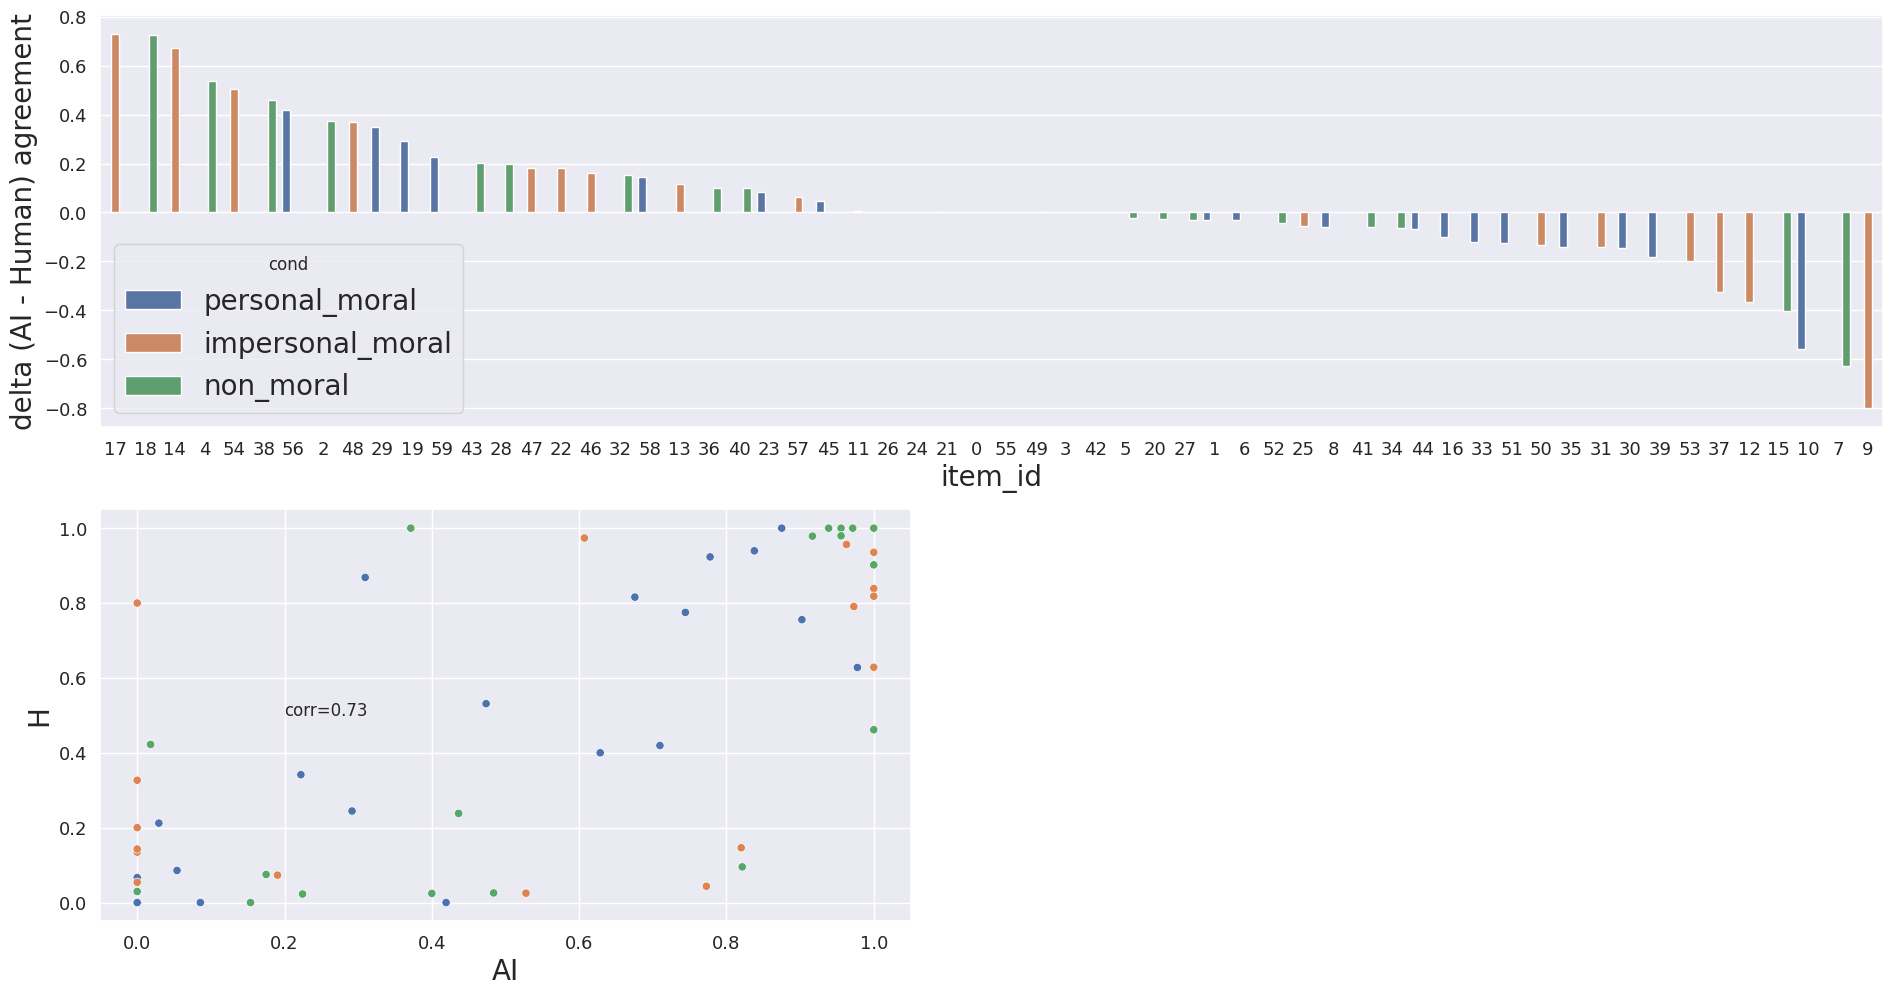

In [37]:
sns.set(
    rc={'figure.figsize':(23,12), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 13
        , 'ytick.labelsize': 13, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
df['agree_a0'] = df.a0.str.contains('yes')
df_AI = df[df.source=='AI'].groupby(['title', 'cond'], as_index=False).agree_a0.mean().sort_values('title', ascending=False).rename(columns={'agree_a0': 'AI'})
df_Human = df[df.source=='Human'].groupby(['title', 'cond'], as_index=False).agree_a0.mean().sort_values('title', ascending=False).rename(columns={'agree_a0': 'H'})
diff = pd.concat([df_AI, df_Human.H], axis=1)
diff['diff'] = diff.AI - diff.H
# df_AI.drop('item_id', axis=1, inplace=True)
# df_Human.drop('item_id', axis=1, inplace=True)
# corr.corr()
diff['item_id'] = diff.index


plt.subplot(2, 1, 1)
sns.barplot(x='item_id', y='diff', data=diff, hue='cond', order=diff.sort_values(['diff', 'cond'], ascending=False).index)
plt.ylabel('delta (AI - Human) agreement')
# sns.heatmap(abs(df_AI.AI - df_Human.H), annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar=False)

plt.subplot(2, 2, 3)
sns.scatterplot(x='AI', y='H', data=diff, hue='cond', legend=False)
plt.annotate(f'corr={round(diff.corr().H.values[0], 2)}', xy=(.2, .5))


/tmp/ipykernel_10117/2650520679.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.998937  102   two-sided  1.331664e-14  [-0.22, -0.14]  0.956275   

             BF10  power  
T-test  5.151e+11    1.0  
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.414523  204   two-sided  0.158733  [-0.06, 0.01]  0.197109  0.387   

          power  
T-test  0.29082  
                T  dof alternative         p-val           CI95%   cohen-d  \
T-test -10.814432  204   two-sided  7.719731e-22  [-0.25, -0.17]  1.506954   

             BF10  power  
T-test  4.305e+18    1.0  
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.426359  102   two-sided  0.156818  [-0.04, 0.01]  0.168961  0.291   

          power  
T-test  0.39704  
               T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test  0.318403  102   two-sided  0.75083  [-0.02, 0.03]  0.036365  0.115   

           power  
T-test  0.0654

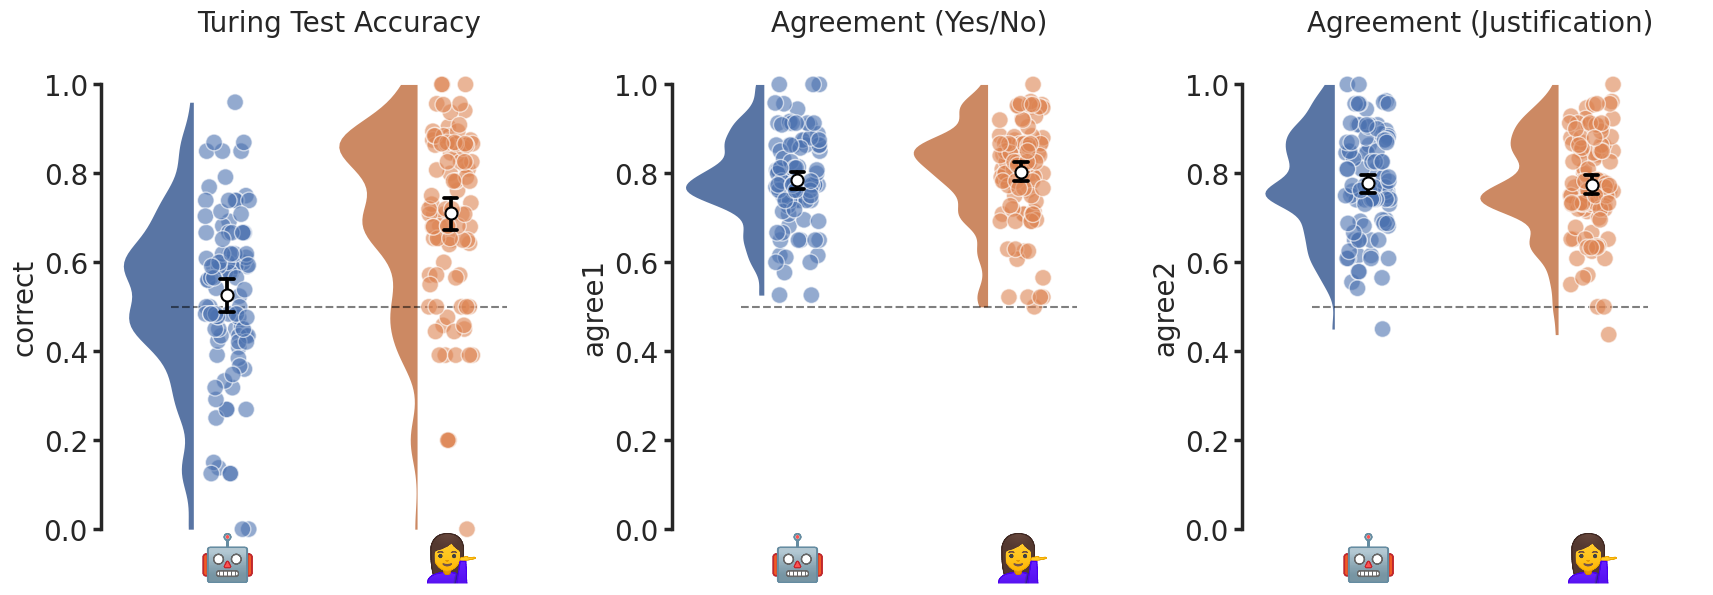

In [38]:
sns.set(
    rc={'figure.figsize':(23,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# -------------------------------------------------------------------------------
# Plot 1: Turing Test 
# -------------------------------------------------------------------------------
avg = df[df.q_id==2].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 1)
# sns.barplot(x='source', y='correct', data=avg, errorbar='se'
# sns.stripplot(x='source', y='correct', data=avg, alpha=0.5, jitter=0.1, size=15, color='black')
#
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='correct', markersize=12, df=avg, order=['AI', 'Human'])
plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.title('Turing Test Accuracy')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);

# AI correct and Human correct is significantly diff
print(pg.ttest(avg[avg.source=='AI'].correct, avg[avg.source=='Human'].correct, paired=True))
n = len(avg[avg.source=='AI'].correct)
print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='AI'].correct))
print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='Human'].correct))

# -------------------------------------------------------------------------------
# Plot 2: Agreement 1
# -------------------------------------------------------------------------------
avg = df[df.q_id==0].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree1', markersize=12, df=avg, order=['AI', 'Human'])
# sns.barplot(x='source', y='agree1', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree1', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.title('Agreement (Yes/No)')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
# AI agree1 and Human agree1 is significantly diff
print(pg.ttest(avg[avg.source=='AI'].agree1, avg[avg.source=='Human'].agree1, paired=True))
# n = len(avg[avg.source=='AI'].correct)
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='AI'].correct))
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='Human'].correct))

# -------------------------------------------------------------------------------
# Plot 3: Agreement 2
# -------------------------------------------------------------------------------
avg = df[df.q_id==1].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 3)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree2', markersize=12, df=avg, order=['AI', 'Human'])
# sns.barplot(x='source', y='agree2', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree2', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
# AI agree2 and Human agree2 is significantly diff
print(pg.ttest(avg[avg.source=='AI'].agree2, avg[avg.source=='Human'].agree2, paired=True))


# -------------------------------------------------------------------------------
# Plot 4: RT
# -------------------------------------------------------------------------------
#avg = df.groupby(['prolific_id', 'source'], as_index=False).mean()
#plt.subplot(1, 4, 4)
## plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
## plt.plot([-1, 2], [0.5, 0.5], '--', color='black', alpha=0.5)
##sns.barplot(x='source', y='rt', data=avg, errorbar='se')
##sns.stripplot(x='source', y='rt', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
#raincloud(x='source', y='rt', markersize=12, df=avg, order=['AI', 'Human'])
#plt.ylim(0, 100000)
#plt.title('RT (ms)')
#plt.xlabel('')
#sns.despine(offset=10, trim=True, bottom=True);
#plt.xticks([])
#plt.gca().spines['left'].set_linewidth(2.5)
#for i, c in enumerate(avg.source.unique()):
#    offset_image(i, c, plt.gca(), size=0.3)
#
plt.tight_layout()

/tmp/ipykernel_10117/1490173210.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')
/tmp/ipykernel_10117/1490173210.py:42: RuntimeWarning: invalid value encountered in double_scalars
  'd_prime': float(stats.norm.ppf(hits['id'].values[i]) - stats.norm.ppf(false['id'].values[i]))})


          n         r          CI95%     p-val   BF10     power
pearson  99  0.086053  [-0.11, 0.28]  0.397044  0.179  0.135581
                            OLS Regression Results                            
Dep. Variable:                 agree1   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7237
Date:                Wed, 08 Feb 2023   Prob (F-statistic):              0.397
Time:                        15:00:27   Log-Likelihood:                 89.939
No. Observations:                  99   AIC:                            -175.9
Df Residuals:                      97   BIC:                            -170.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

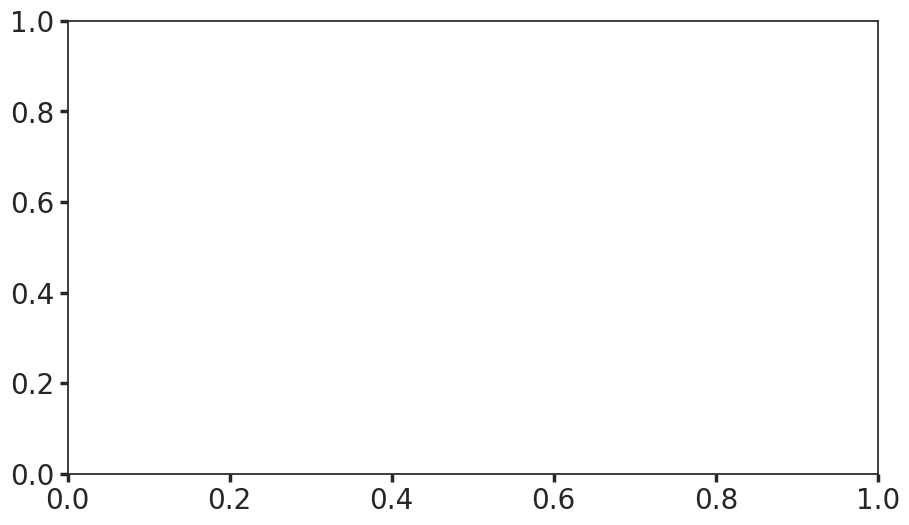

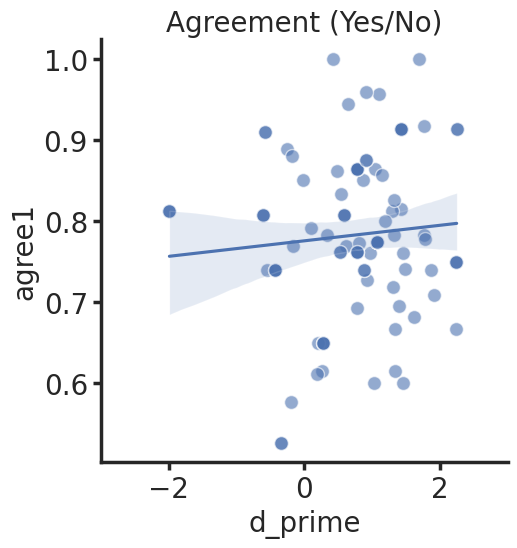

          n         r        CI95%     p-val  BF10     power
pearson  99  0.224832  [0.03, 0.4]  0.025263  1.48  0.614516
                            OLS Regression Results                            
Dep. Variable:                 agree2   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     5.164
Date:                Wed, 08 Feb 2023   Prob (F-statistic):             0.0253
Time:                        15:00:27   Log-Likelihood:                 78.080
No. Observations:                  99   AIC:                            -152.2
Df Residuals:                      97   BIC:                            -147.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

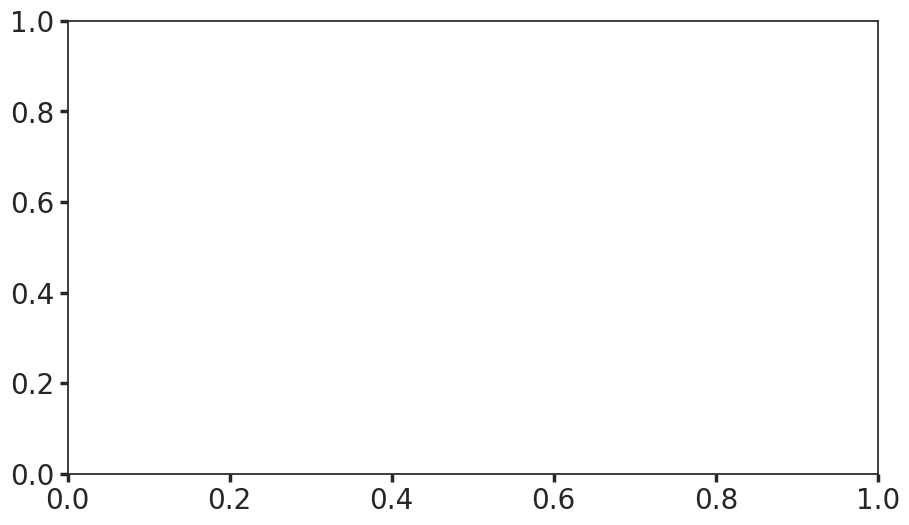

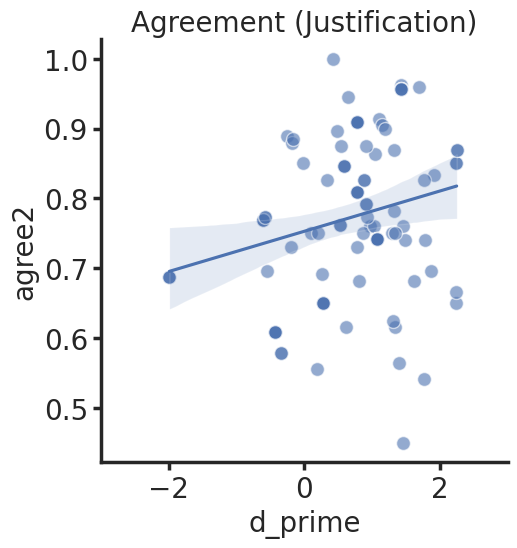

In [39]:
import scipy.stats as stats

sns.set(
    rc={'figure.figsize':(23,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5

false = pd.DataFrame()
hits = pd.DataFrame()

labels = ['id', 'agree1', 'agree2']
labels = ['id']
titles = ['Agreement (Yes/No)', 'Agreement (Justification)']

false['id'] = 1 - df[(df.source == 'Human') & (df.q_id == 2)
                     ].groupby('prolific_id', as_index=False).mean().correct
hits['id'] = df[(df.source == 'AI') & (df.q_id == 2)].groupby(
    'prolific_id', as_index=False).mean().correct
false['agree1'] = 1 - df[(df.source == 'Human') & (df.q_id == 0)
                         ].groupby('prolific_id', as_index=False).mean().agree1
hits['agree1'] = df[(df.source == 'AI') & (df.q_id == 0)].groupby(
    'prolific_id', as_index=False).mean().agree1
false['agree2'] = 1 - df[(df.source == 'Human') & (df.q_id == 1)
                         ].groupby('prolific_id', as_index=False).mean().agree2
hits['agree2'] = df[(df.source == 'AI') & (df.q_id == 1)].groupby(
    'prolific_id', as_index=False).mean().agree2

d = []
for i in range(false['id'].shape[0]):
    d.append({'agree1': hits['agree1'].values[i],
              'agree2': hits['agree2'].values[i],
              'd_prime': float(stats.norm.ppf(hits['id'].values[i]) - stats.norm.ppf(false['id'].values[i]))})

d = pd.DataFrame(d)  # plt.subplot(1, 4, 1)
d = d[~d.isin([np.nan, np.inf, -np.inf]).any(1)]

count = 0
d['d_prime'] = d['d_prime'].astype(float)
d['agree1'] = d['agree1'].astype(float)
for agree in ('agree1', 'agree2'):
    count += 1
    plt.subplot(1, 2, count)
    sns.lmplot(x='d_prime', y=agree, data=d, scatter_kws={
               'alpha': 0.6, 's': 100, 'edgecolor': 'white'})
# snspine(offset=10, trim=True)
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)
    plt.xlim([-3, 3])
    plt.title(titles[count-1])
    print(pg.corr(d['d_prime'], d[agree]))
    print(sm.formula.ols(f'{agree} ~ d_prime', data=d).fit().summary())
    plt.show()


/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Optimization terminated successfully.
         Current function value: 0.642511
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      a   No. Observations:                 4738
Model:                          Logit   Df Residuals:                     4736
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Feb 2023   Pseudo R-squ.:                 0.04331
Time:                        15:00:28   Log-Likelihood:                -3044.2
converged:                       True   LL-Null:                       -3182.0
Covariance Type:            nonrobust   LLR p-value:                 6.635e-62
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0239      0.050    -20.647      0.000      -1.121      -0.927
justif_len     0.0034      0.

Text(0, 0, '***')

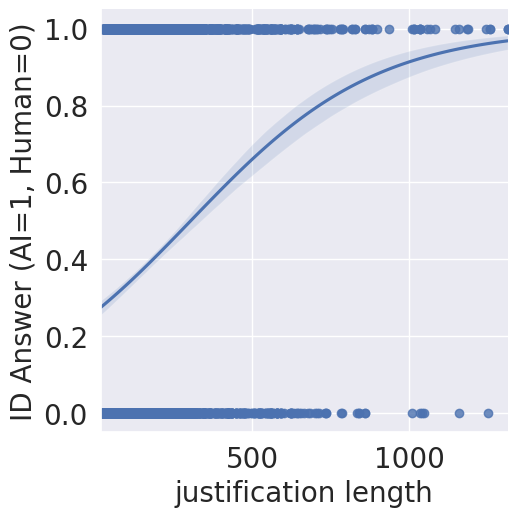

In [40]:
sns.set({'figure.figsize':(6,6), "figure.dpi": 100, 'legend.fontsize': 20,})
df['justif_len'] = df.a1.str.len()
dff = df[df.q_id == 2]
dff.loc[dff.answer=='AI', 'a'] = 1
dff.loc[dff.answer=='Human', 'a'] = 0


print(sm.Logit.from_formula('a ~ justif_len', data=dff).fit().summary())
sns.lmplot(x='justif_len', y='a', data=dff, logistic=True)
plt.ylabel('ID Answer (AI=1, Human=0)')
plt.xlabel('justification length')
plt.annotate('***', xy=(0, 0), fontsize=20)

<AxesSubplot:ylabel='d_prime'>

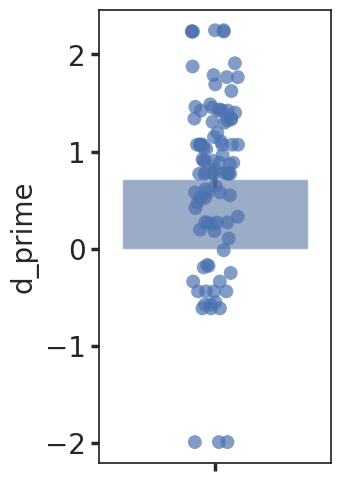

In [41]:
sns.set({'figure.figsize':(3, 6), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')
sns.barplot(y='d_prime', data=d, ci=68, alpha=.6)
sns.stripplot(y='d_prime', data=d, size=10, edgecolor='white', alpha=.7)

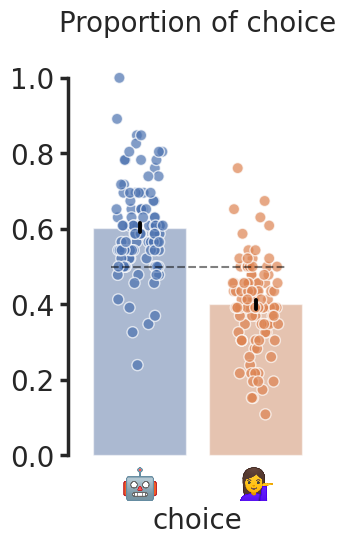

In [42]:

sns.set({'figure.figsize':(3, 6), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')
sns.color_palette('deep')
# -------------------------------------------------------------------------------
# Plot: Consistency agreement
# -------------------------------------------------------------------------------
avg = df[df.q_id.isin([0])].groupby(['prolific_id', 'source'], as_index=False).mean()
x = df[df.q_id==2].groupby('prolific_id').answer.value_counts(normalize=True).keys().tolist()
x = [item[1] for item in x]
y = df[df.q_id==2].groupby('prolific_id').answer.value_counts(normalize=True).tolist()

plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)

# raincloud(x=x, y=y, markersize=12, df=None, order=['AI', 'Human'])
sns.barplot(x=x, y=y, ci=68, alpha=.5, zorder=0)
sns.stripplot(x=x, y=y,  alpha=0.7, jitter=0.2, size=8, linewidth=1, edgecolor='white', zorder=1)
sns.pointplot(x=x, y=y, ci=68, color='black', scale=0, errorbar='se', join=False, zorder=2)
plt.ylim(-.1, 1.1)
plt.title('Proportion of choice')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xlabel('choice')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.2)



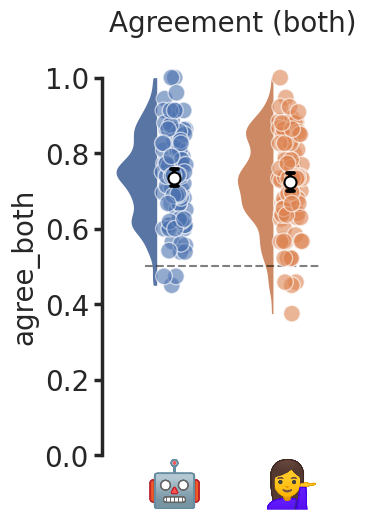

In [43]:
sns.set_style('ticks')
sns.color_palette('deep')
# -------------------------------------------------------------------------------
# Plot: Consistency agreement
# -------------------------------------------------------------------------------
avg = df[df.q_id.isin([0])].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
# sns.barplot(x='source', y='agree2', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree2', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(-.1, 1.1)
plt.title('Agreement (both)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)



([], [])

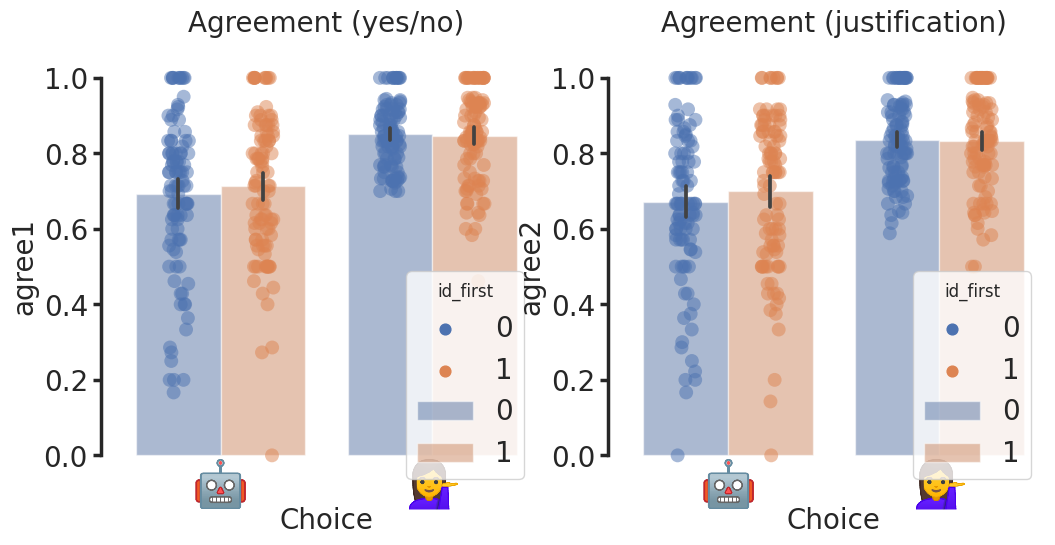

In [44]:
sns.set({'figure.figsize':(12, 6), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')
sns.color_palette('deep')
# -------------------------------------------------------------------------------
# Plot:  agreement according to id first
# -------------------------------------------------------------------------------
plt.subplot(1, 2, 1)
avg = df[df.q_id.isin([0])].groupby(['prolific_id', 'turing', 'id_first'], as_index=False).mean()
# plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='id_first', y='agree1', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='turing', y='agree1', data=avg,  hue='id_first', dodge=True, alpha=.5, zorder=0)
g = sns.stripplot(x='turing', y='agree1', data=avg, alpha=0.5, jitter=0.1,
    size=10, hue='id_first', dodge=True, edgecolor='white', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement (yes/no)')
plt.xlabel('Choice')
for i, c in enumerate(avg.turing.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xticks([])

# -------------------------------------------------------------------------------
# Plot:  agreement justification according to id first
# -------------------------------------------------------------------------------
plt.subplot(1, 2, 2)
avg = df[df.q_id.isin([1])].groupby(['prolific_id', 'turing', 'id_first'], as_index=False).mean()
# plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='id_first', y='agree1', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='turing', y='agree2', data=avg,  hue='id_first', dodge=True, alpha=.5, zorder=0)
g = sns.stripplot(x='turing', y='agree2', data=avg, alpha=0.5, jitter=0.1,
    size=10, hue='id_first', dodge=True, edgecolor='white', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement (justification)')
for i, c in enumerate(avg.turing.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xlabel('Choice')
plt.xticks([])




             Source        SS  ddof1  ddof2        MS          F  \
0            source  0.151078      1     98  0.151078   4.731782   
1           correct  0.516567      1     98  0.516567  19.542456   
2  source * correct  2.093444      1     98  2.093444  46.203911   

          p-unc     p-GG-corr       ng2  eps  
0  3.201538e-02  3.201538e-02  0.010683  1.0  
1  2.545476e-05  2.545476e-05  0.035606  1.0  
2  8.390629e-10  8.390629e-10  0.130151  1.0  
             Source        SS  ddof1  ddof2        MS          F  \
0            source  0.188172      1     98  0.188172   7.406834   
1           correct  0.394175      1     98  0.394175  13.417182   
2  source * correct  2.074359      1     98  2.074359  49.573285   

          p-unc     p-GG-corr       ng2  eps  
0  7.690508e-03  7.690508e-03  0.013673  1.0  
1  4.044606e-04  4.044606e-04  0.028219  1.0  
2  2.646013e-10  2.646013e-10  0.132560  1.0  


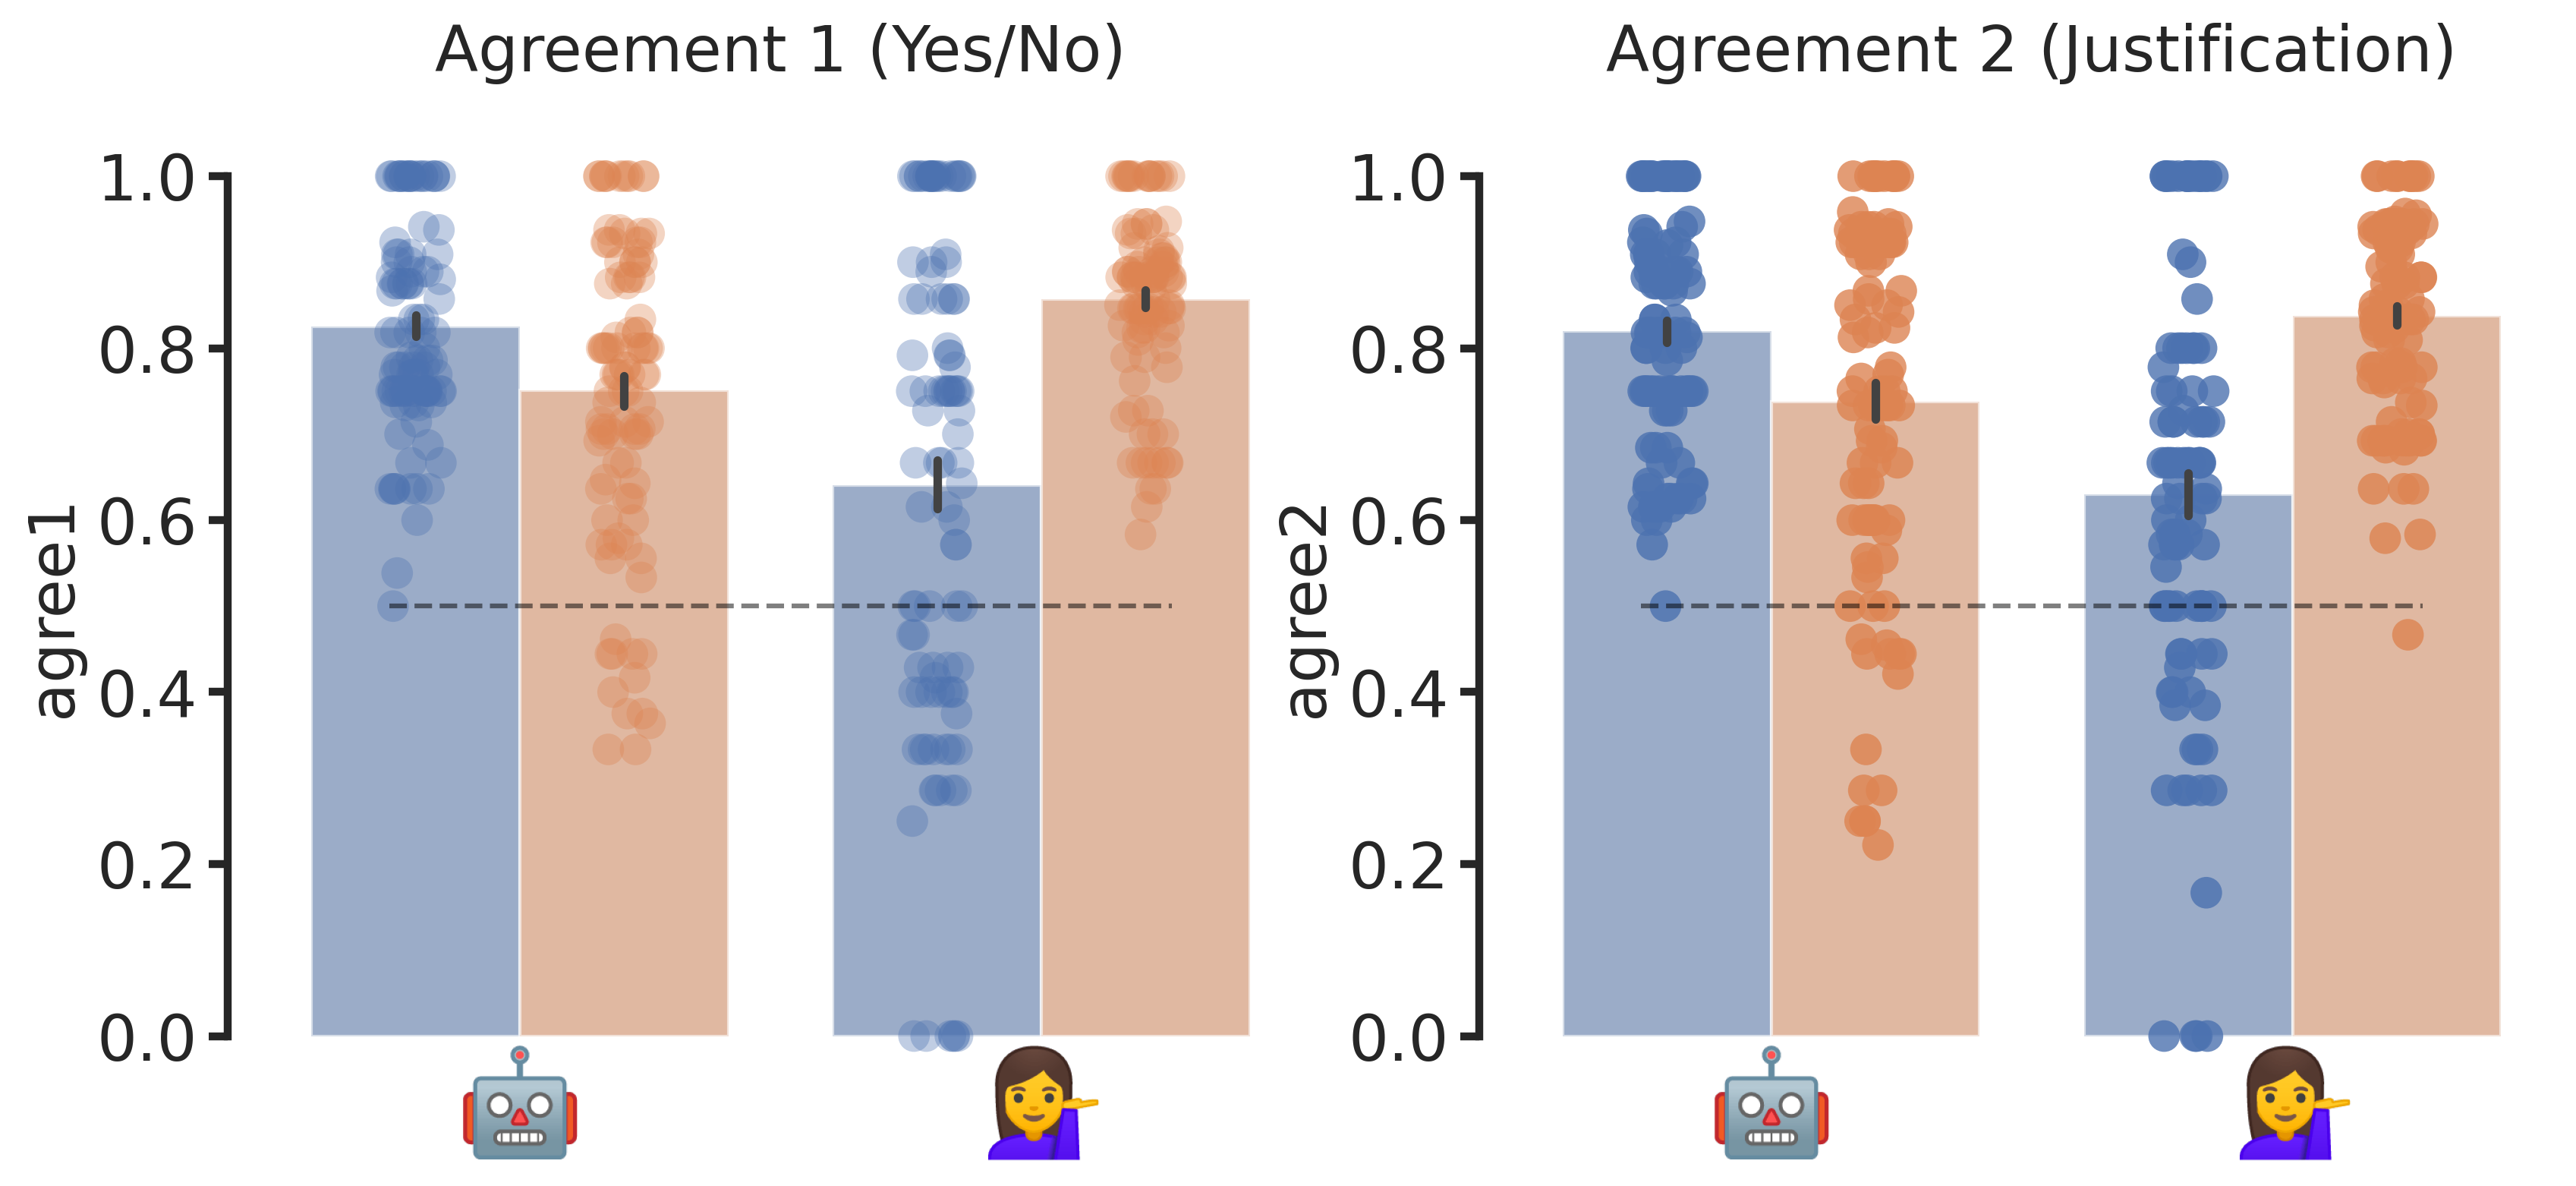

In [45]:
sns.set(
    rc={'figure.figsize':(13,6), "figure.dpi": 300, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------

avg = df.groupby(['prolific_id', 'source', 'correct'], as_index=False).mean()

plt.subplot(1, 2, 1)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree1', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0, dodge=True)
sns.stripplot(x='source', y='agree1', data=avg, alpha=0.35, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement 1 (Yes/No)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree1', within=['source', 'correct'], subject='prolific_id', detailed=True))


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# -------------------------------------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree2', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0)
sns.stripplot(x='source', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1, edgecolor='white')
plt.ylim(-.1, 1.1)
plt.title('Agreement 2 (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree2', within=['source', 'correct'], subject='prolific_id', detailed=True))

In [46]:
df.groupby(['prolific_id', 'source', 'correct'], as_index=False).size()


,prolific_id,source,correct,size
0,5483702ffdf99b24c654b810,AI,False,45
1,5483702ffdf99b24c654b810,AI,True,21
2,5483702ffdf99b24c654b810,Human,False,39
3,5483702ffdf99b24c654b810,Human,True,33
4,54b9acd9fdf99b34ce2578f9,AI,False,27
...,...,...,...,...
401,63d4005611fc905186f61eac,Human,True,45
402,63d401296ac856e37cce7cb9,AI,False,33
403,63d401296ac856e37cce7cb9,AI,True,30
404,63d401296ac856e37cce7cb9,Human,False,21


  Source        SS   DF        MS         F     p-unc       ng2       eps
0   cond  0.060889    2  0.030444  2.315306  0.101325  0.005776  0.972851
1  Error  2.682432  204  0.013149       NaN       NaN       NaN       NaN
  Source        SS   DF        MS         F         p-unc     p-GG-corr  \
0   cond  0.440312    2  0.220156  16.88468  1.638236e-07  4.021839e-07   
1  Error  2.659918  204  0.013039       NaN           NaN           NaN   

        ng2       eps sphericity  W-spher  p-spher  
0  0.086389  0.927119      False  0.92139  0.01601  
1       NaN       NaN        NaN      NaN      NaN  


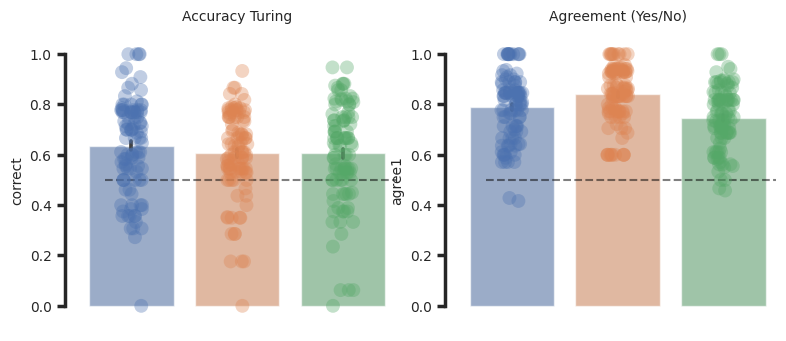

In [47]:
sns.set(
    rc={'figure.figsize':(9,4), "figure.dpi": 100, 'legend.fontsize': 10, 'axes.labelsize': 10, 'axes.titlesize': 10,
      'xtick.labelsize': 10, 'ytick.labelsize': 10, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------

avg = df.groupby(['prolific_id', 'cond'], as_index=False).mean()
plt.subplot(1, 2, 1)
plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='cond', y='correct', data=avg, ci=68, alpha=0.6)
sns.stripplot(x='cond', y='correct', data=avg, alpha=0.35, jitter=0.1, size=10, dodge=True)
plt.ylim(-.1, 1.1)
plt.title('Accuracy Turing')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
# for i, c in enumerate(avg.source.unique()):
    # offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='correct', within='cond', subject='prolific_id', detailed=True))


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# -------------------------------------------------------------------------------
plt.subplot(1, 2, 2)
# avg = df.groupby(['prolific_id', 'cond', 'agree1'], as_index=False).mean()
plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='cond', y='agree1', data=avg, ci=68, alpha=0.6)
sns.stripplot(x='cond', y='agree1', data=avg, alpha=0.35, jitter=0.1, size=10, dodge=True)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Yes/No)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
# for i, c in enumerate(avg.source.unique()):
    # offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree1', within='cond', subject='prolific_id', detailed=True))
